## Problem definition 

For the purpose of the FDL course you will have to implement and solve a remote sensing problem using recent deep learning techniques. In particular, the main objective of this challenge is to segment images acquired by a small UAV (sUAV) at the area on Houston, Texas. These images were acquired in order to assess the damages on residential and public properties after Hurricane Harvey. In total there are 25 categories of segments (e.g. roof, trees, pools etc.).

The task is to design and implement a deep learning model in order to perform the automatic segmentation of such images. The model can be trained using the train images which contain pixel-wise annotations. Using the trained model, a prediction on the test images should be performed and submitted on the platform. Depending on the performance of the submitted file and the leaderboard you will be ranked accordingly using macro F1 score.

25 Classes:
Following classes are present
0: Background
1: Property Roof
2: Secondary Structure
3: Swimming Pool
4: Vehicle
5: Grass
6: Trees / Shrubs
7: Solar Panels
8: Chimney
9: Street Light
10: Window
11: Satellite Antenna
12: Garbage Bins
13: Trampoline
14: Road/Highway
15: Under Construction / In Progress Status
16: Power Lines & Cables
17: Water Tank / Oil Tank
18: Parking Area - Commercial
19: Sports Complex / Arena
20: Industrial Site
21: Dense Vegetation / Forest
22: Water Body
23: Flooded
24: Boat

In [2]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#create data path
mypath = "/content/drive/My Drive/essec assignment/Deep Learning/"
save_folder = "/content/drive/My Drive/essec assignment/Deep Learning/Models"
output_folder = "/content/drive/My Drive/essec assignment/Deep Learning/test_preds/"
train_img_numpy_files = "/content/drive/My Drive/essec assignment/Deep Learning/Numpy/train_img"
train_msk_numpy_files = "/content/drive/My Drive/essec assignment/Deep Learning/Numpy/train_msk"
test_img_numpy_files = "/content/drive/My Drive/essec assignment/Deep Learning/Numpy/test_img"
# ordered_files = "/content/drive/My Drive/essec assignment/Deep Learning/Numpy/ordered_images.csv"

In [4]:
#unzip the data from the drive
!unzip "/content/drive/My Drive/essec assignment/Deep Learning/fdl21-fdl-dsba.zip"

Archive:  /content/drive/My Drive/essec assignment/Deep Learning/fdl21-fdl-dsba.zip
   creating: fdl21-fdl-dsba/
  inflating: __MACOSX/._fdl21-fdl-dsba  
   creating: fdl21-fdl-dsba/test_images/
   creating: fdl21-fdl-dsba/train_images/
   creating: fdl21-fdl-dsba/train_masks/
  inflating: fdl21-fdl-dsba/prepare_submission.py  
  inflating: __MACOSX/fdl21-fdl-dsba/._prepare_submission.py  
   creating: fdl21-fdl-dsba/test_images/test_images/
   creating: fdl21-fdl-dsba/train_images/train_images/
   creating: fdl21-fdl-dsba/train_masks/train_masks/
  inflating: fdl21-fdl-dsba/test_images/test_images/6574.jpg  
  inflating: __MACOSX/fdl21-fdl-dsba/test_images/test_images/._6574.jpg  
  inflating: fdl21-fdl-dsba/test_images/test_images/6560.jpg  
  inflating: __MACOSX/fdl21-fdl-dsba/test_images/test_images/._6560.jpg  
  inflating: fdl21-fdl-dsba/test_images/test_images/7521.jpg  
  inflating: __MACOSX/fdl21-fdl-dsba/test_images/test_images/._7521.jpg  
  inflating: fdl21-fdl-dsba/test_im

In [5]:
#importing data
import glob         # file operations
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image # Image I/O (e.g. Image.open)
import matplotlib.pyplot as plt
import cv2

In [78]:
train_images_path = '/content/fdl21-fdl-dsba/train_images/train_images/'
train_masks_path = '/content/fdl21-fdl-dsba/train_masks/train_masks/'
test_image_path = '/content/fdl21-fdl-dsba/test_images/test_images/'

In [79]:
# Get the directories of all images and masks
train_x = sorted(glob.glob(train_images_path+'*.jpg'))
train_y = sorted(glob.glob(train_masks_path+'*.png'))
test_x = sorted(glob.glob(test_image_path+'*.jpg'))

print('Train Images:', len(train_x))
print('Train Masked:', len(train_y))
print('Test Images:', len(test_x))

Train Images: 261
Train Masked: 261
Test Images: 112


Image Size: (3000, 4000)
Mask Size: (3000, 4000)


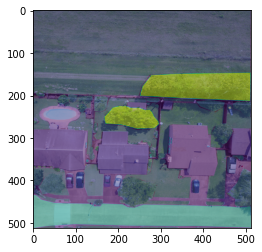

In [81]:
# Randomly select and image/mask pair from the training set
idx = np.random.choice(range(len(train_x)))
img = Image.open(train_x[idx])
msk = Image.open(train_y[idx])

print('Image Size:',img.size)
print('Mask Size:',msk.size)

# Show the image
plt.imshow(img.resize((512,512)))
plt.imshow(msk.resize((512,512)), alpha=0.5)
plt.show()

# Creating data loaders

In [9]:
img_size = 512
batch_size = 5

In [ ]:
train_x_list = []
train_y_list = []
test_x_list = []

for idx in range(len(train_x)):

  img = Image.open(train_x[idx])
  msk = Image.open(train_y[idx])

  train_x_list.append(np.array(img.resize((img_size,img_size))))
  train_y_list.append(np.array(msk.resize((img_size,img_size))))

for idx in range(len(test_x)):

  img = Image.open(test_x[idx])
  test_x_list.append(np.array(img.resize((img_size,img_size))))


train_x_np = np.array(train_x_list)
train_y_np = np.array(train_y_list)
test_x_np = np.array(test_x_list)

print(train_x_np.shape)
print(train_y_np.shape)
print(test_x_np.shape)

In [13]:
# Save npy files for faster loading for later testing

# np.save(train_img_numpy_files,train_x_np)
# np.save(train_msk_numpy_files,train_y_np)
# np.save(test_img_numpy_files,test_x_np)

In [14]:
# Loading from npy file saves time in unzipping files and converting all to np array

# train_x_np = np.load(train_img_numpy_files+".npy")
# train_y_np = np.load(train_msk_numpy_files+".npy")
# test_x_np = np.load(test_img_numpy_files+".npy")


In [15]:
np.unique(train_y_np)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=uint8)

27 unique values were seen so we have created our models based on 27 possible classes.

In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [17]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform = None, target_transform = None):
    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform
      
  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)
    else:
      y = torch.from_numpy(y).long()
    
    return x, y
  
  def __len__(self):
    return len(self.data)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_x_np, train_y_np, train_size=0.8, random_state=0)

In [20]:
my_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_dataset = MyDataset(X_train, y_train, my_transform)
val_dataset = MyDataset(X_val, y_val, my_transform)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)

complete_dataset = MyDataset(train_x_np, train_y_np, my_transform)
complete_dataloader = DataLoader(complete_dataset, batch_size = batch_size)

# Creating Model architecture

### Building a UNet model

In [21]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

### Building another UNet model

In [22]:
class UNet2(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet2, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X)
        contracting_12_out = self.contracting_12(contracting_11_out)
        contracting_21_out = self.contracting_21(contracting_12_out)
        contracting_22_out = self.contracting_22(contracting_21_out)
        contracting_31_out = self.contracting_31(contracting_22_out)
        contracting_32_out = self.contracting_32(contracting_31_out)
        contracting_41_out = self.contracting_41(contracting_32_out)
        contracting_42_out = self.contracting_42(contracting_41_out)
        middle_out = self.middle(contracting_42_out)
        expansive_11_out = self.expansive_11(middle_out)
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1))
        expansive_21_out = self.expansive_21(expansive_12_out)
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1))
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

### Torchvision model based

In [23]:
import torchvision.models

def convrelu(in_channels, out_channels, kernel, padding):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    nn.ReLU(inplace=True),
  )


class ResNetUNet(nn.Module):
  def __init__(self, n_class):
    super().__init__()

    self.base_model = torchvision.models.resnet18(pretrained=True)
    self.base_layers = list(self.base_model.children())

    self.layer0 = nn.Sequential(*self.base_layers[:3])
    self.layer0_1x1 = convrelu(64, 64, 1, 0)
    self.layer1 = nn.Sequential(*self.base_layers[3:5])
    self.layer1_1x1 = convrelu(64, 64, 1, 0)
    self.layer2 = self.base_layers[5]
    self.layer2_1x1 = convrelu(128, 128, 1, 0)
    self.layer3 = self.base_layers[6]
    self.layer3_1x1 = convrelu(256, 256, 1, 0)
    self.layer4 = self.base_layers[7]
    self.layer4_1x1 = convrelu(512, 512, 1, 0)

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
    self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
    self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
    self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

    self.conv_original_size0 = convrelu(3, 64, 3, 1)
    self.conv_original_size1 = convrelu(64, 64, 3, 1)
    self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

    self.conv_last = nn.Conv2d(64, n_class, 1)

  def forward(self, input):
    x_original = self.conv_original_size0(input)
    x_original = self.conv_original_size1(x_original)

    layer0 = self.layer0(input)
    layer1 = self.layer1(layer0)
    layer2 = self.layer2(layer1)
    layer3 = self.layer3(layer2)
    layer4 = self.layer4(layer3)

    layer4 = self.layer4_1x1(layer4)
    x = self.upsample(layer4)
    layer3 = self.layer3_1x1(layer3)
    x = torch.cat([x, layer3], dim=1)
    x = self.conv_up3(x)

    x = self.upsample(x)
    layer2 = self.layer2_1x1(layer2)
    x = torch.cat([x, layer2], dim=1)
    x = self.conv_up2(x)

    x = self.upsample(x)
    layer1 = self.layer1_1x1(layer1)
    x = torch.cat([x, layer1], dim=1)
    x = self.conv_up1(x)

    x = self.upsample(x)
    layer0 = self.layer0_1x1(layer0)
    x = torch.cat([x, layer0], dim=1)
    x = self.conv_up0(x)

    x = self.upsample(x)
    x = torch.cat([x, x_original], dim=1)
    x = self.conv_original_size2(x)

    out = self.conv_last(x)

    return out

### Segmentation model pytorch

In [24]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp


     |████████████████████████████████| 88 kB 5.0 MB/s 
     |████████████████████████████████| 376 kB 39.8 MB/s 
     |████████████████████████████████| 58 kB 8.9 MB/s 


In [82]:
n_classes = 27
temp_model = smp.DeepLabV3('resnet34', encoder_weights='imagenet', classes=n_classes, activation=None)

### Another segmentation model pytorch

In [26]:
n_classes = 27
temp_model = smp.FPN('resnet34', encoder_weights='imagenet', classes=n_classes, activation="sigmoid")

# Training the model and validating

In [28]:
# !pip install torchnet
# import torchnet as tnt
from tqdm import tqdm
import torch.nn.functional as F

In [29]:
def write_results(save_folder, epoch, train_acc, val_acc, train_loss, val_loss):
    ff=open('{}/progress.txt'.format(save_folder),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_OA: ')
    ff.write(str('%.3f' % train_acc))
    ff.write(' VAL_OA: ')
    ff.write(str('%.3f' % val_acc))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')

def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('{}/chart.png'.format(save_folder))

In [30]:
class DiceLoss(nn.Module):
    
    def __init__(self, weight=None):
        super(DiceLoss, self).__init__()
        if weight is not None:
            weight = torch.Tensor(weight)
            self.weight = weight / torch.sum(weight)
        self.smooth = 1e-5

    def forward(self, predict, target):
        N, C = predict.size()[:2]
        predict = predict.view(N, C, -1)
        target = target.view(N, 1, -1)

        predict = F.softmax(predict, dim=1)

        target_onehot = torch.zeros(predict.size()).cuda()
        target_onehot.scatter_(1, target, 1)

        intersection = torch.sum(predict * target_onehot, dim=2)
        union = torch.sum(predict.pow(2), dim=2) + torch.sum(target_onehot, dim=2)

        dice_coef = (2 * intersection + self.smooth) / (union + self.smooth)

        if hasattr(self, 'weight'):
            if self.weight.type() != predict.type():
                self.weight = self.weight.type_as(predict)
                dice_coef = dice_coef * self.weight * C
        dice_loss = 1 - torch.mean(dice_coef)

        return dice_loss

In [31]:
def train_validate(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, save_folder):

    total_train_losses = []
    total_val_losses = []

    for epoch in range(1,num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))

        # Training
        model.train()
        train_loss = []

        for i, batch in enumerate(tqdm(train_dataloader)):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs.float())

            loss = criterion(outputs, labels.long()) 

            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        train_loss_mean = np.mean(train_loss)
        total_train_losses.append(train_loss_mean)
        
        # Validating
        model.eval()
        val_loss = []
        val_mask_outputs = []
        
        for i, batch in enumerate(tqdm(val_dataloader)):
            inputs, labels = batch  
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs.float())
            loss = criterion(outputs, labels.long())

            val_loss.append(loss.item())
            outputs = F.softmax(outputs, dim=1)
            outputs = torch.argmax(outputs, dim=1)
            outputs = torch.squeeze(outputs).cpu().numpy()

            val_mask_outputs.append(outputs)

        val_loss_mean = np.mean(val_loss)
        total_val_losses.append(val_loss_mean)

        print("epoch %d: train loss:%0.3f" % (epoch, train_loss_mean))
        print("epoch %d: val loss:%0.3f" % (epoch, val_loss_mean))
        torch.save(model.state_dict(), save_folder + '/model_deep_lab_{}.pt'.format(epoch))

    save_graph(total_train_losses, total_val_losses, num_epochs, save_folder)


In [32]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_classes = 27

# model = UNet(n_classes)
# model = UNet2(n_classes)
# model = ResNetUNet(n_classes)
# model = smp.FPN('resnet34', encoder_weights='imagenet', classes=n_classes, activation="sigmoid")
model = smp.DeepLabV3('resnet34', encoder_weights='imagenet', classes=n_classes, activation=None)


lr = 0.001
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)


criterion = nn.CrossEntropyLoss()
# criterion = DiceLoss()


model.to(device)
num_epochs = 15

Epoch 1/15


100%|██████████| 11/11 [00:03<00:00,  3.44it/s]


epoch 1: train loss:2.041
epoch 1: val loss:1.778
Epoch 2/15


100%|██████████| 11/11 [00:03<00:00,  3.38it/s]


epoch 2: train loss:1.422
epoch 2: val loss:1.514
Epoch 3/15


100%|██████████| 11/11 [00:03<00:00,  3.34it/s]


epoch 3: train loss:1.242
epoch 3: val loss:1.442
Epoch 4/15


100%|██████████| 11/11 [00:03<00:00,  3.32it/s]


epoch 4: train loss:1.120
epoch 4: val loss:1.478
Epoch 5/15


100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


epoch 5: train loss:1.079
epoch 5: val loss:1.190
Epoch 6/15


100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


epoch 6: train loss:0.993
epoch 6: val loss:1.104
Epoch 7/15


100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


epoch 7: train loss:0.945
epoch 7: val loss:1.292
Epoch 8/15


100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


epoch 8: train loss:0.894
epoch 8: val loss:1.112
Epoch 9/15


100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


epoch 9: train loss:0.821
epoch 9: val loss:1.248
Epoch 10/15


100%|██████████| 11/11 [00:03<00:00,  3.29it/s]


epoch 10: train loss:0.908
epoch 10: val loss:1.237
Epoch 11/15


100%|██████████| 11/11 [00:03<00:00,  3.29it/s]


epoch 11: train loss:0.829
epoch 11: val loss:1.132
Epoch 12/15


100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


epoch 12: train loss:0.750
epoch 12: val loss:1.117
Epoch 13/15


100%|██████████| 11/11 [00:03<00:00,  3.29it/s]


epoch 13: train loss:0.702
epoch 13: val loss:1.087
Epoch 14/15


100%|██████████| 11/11 [00:03<00:00,  3.29it/s]


epoch 14: train loss:0.651
epoch 14: val loss:1.117
Epoch 15/15


100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


epoch 15: train loss:0.623
epoch 15: val loss:1.230


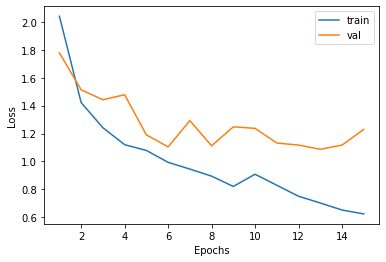

In [65]:
train_validate(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs, save_folder)

# Accuracy

In [66]:
# model.load_state_dict(torch.load(save_folder+"/model_15.pt", map_location=device))

In [67]:
# model.to(device)
model.eval()

val_dataloader_accuracy = DataLoader(val_dataset, batch_size = 1)
val_loss = []
val_mask_outputs = []

for i, batch in enumerate(tqdm(val_dataloader_accuracy)):
    inputs, labels = batch  
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs.float())
    loss = criterion(outputs, labels.long())

    val_loss.append(loss.item())
    outputs = F.softmax(outputs, dim=1)
    outputs = torch.argmax(outputs, dim=1)
    outputs = torch.squeeze(outputs).cpu().numpy()

    val_mask_outputs.append(outputs)

100%|██████████| 53/53 [00:04<00:00, 11.72it/s]


In [68]:
!pip install torchmetrics

In [69]:
def multi_acc(pred, label):
    corrects = torch.eq(probs,label).int()
    acc = corrects.sum()/corrects.numel()
    return acc

from torchmetrics import IoU
iou = IoU(num_classes=27)

def diceloss_forward(pred, target, smooth=0.0001):
    
    intersection = torch.eq(pred, target).int()
    union = float(intersection.numel())
    return ((2. * intersection.sum() + smooth) / (union + smooth) )


In [ ]:
multi_acc_accuracy = []
iou_accuracy = []
dicecoefficient = []

for i in range(0,len(val_mask_outputs)):
  label = torch.from_numpy(y_val[i]) #actual
  probs = torch.from_numpy(val_mask_outputs[i]) #predicted
  
  multi_acc_accuracy.append(multi_acc(probs, label).numpy())
  iou_accuracy.append(iou(probs, label).numpy())
  dicecoefficient.append(diceloss_forward(probs, label))

# print(y_val[0].shape, val_mask_outputs[0].shape)
print("Pixel Similarity: ",np.mean(multi_acc_accuracy))
print("Intersection over Union (IoU): ", np.mean(iou_accuracy))
print("Mean dice coefficient: ", np.mean(dicecoefficient))

# Predicting test-masks

In [71]:
model.eval()

train_mask_outputs = []
test_mask_outputs = []
with torch.no_grad():
  i=0
  for inp in test_x_np:
    
    inp = my_transform(inp)
    inp = inp.unsqueeze(0)

    inputs = inp.to(device)

    outputs = model(inputs)
    # Converts the network output values to a probabilistic array, takes the Index corresponding to the larger values, and finally removes the first dimension
    outputs = F.softmax(outputs, dim=1)
    outputs = torch.argmax(outputs, dim=1)
    outputs = torch.squeeze(outputs).cpu().numpy()

    test_mask_outputs.append(outputs)
    folder = output_folder + test_id[i] + '.png'
    # print(outputs.shape)
    
    cv2.imwrite(folder, outputs)
    i=i+1

In [72]:
to_continue = True
    # also predicting for 10 train data images to compare with actual masks
if to_continue:
  with torch.no_grad():
    for inp in train_x_np[:10]:
      
      inp = my_transform(inp)
      inp = inp.unsqueeze(0)

      inputs = inp.to(device)

      outputs = model(inputs)
      # Converts the network output values to a probabilistic array, takes the Index corresponding to the larger values, and finally removes the first dimension
      outputs = F.softmax(outputs, dim=1)
      outputs = torch.argmax(outputs, dim=1)
      outputs = torch.squeeze(outputs).cpu().numpy()

      train_mask_outputs.append(outputs)


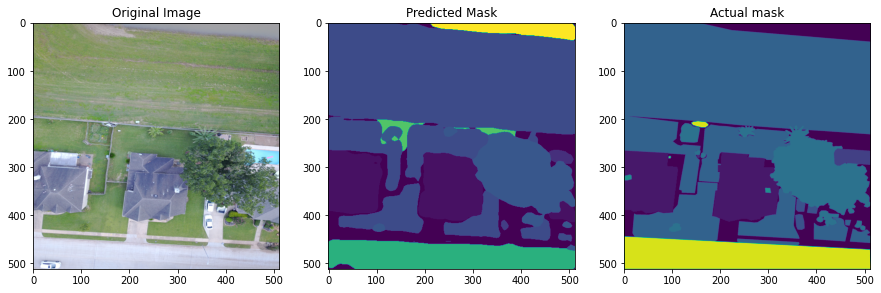

In [73]:
# Change these two params and run
idx = np.random.randint(1,10)
from_train = True
#############################
fig, arr  = plt.subplots(1,3,figsize=(15, 10))

if from_train:
  img = train_x_np[idx]
  mask = train_mask_outputs[idx]
  act_mask = train_y_np[idx]
else:
  img = test_x_np[idx]
  mask = test_mask_outputs[idx]

arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Predicted Mask')

if from_train:
  arr[2].imshow(act_mask)
  arr[2].set_title('Actual mask')
else:
  arr[2].imshow(img)
  arr[2].imshow(mask,alpha=0.5)
  arr[2].set_title('Overlap')


# Generating submission output file

In [74]:
#prepare_submission.py

import os

from PIL import Image
import numpy as np

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles():
    """Used for Kaggle submission: predicts and encode all test images"""
    dir = output_folder

    N = len(list(os.listdir(dir)))
    with open('submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(dir)):
            # print('{}/{}'.format(index, N))

            mask = Image.open(dir + i)
            mask = mask.resize((1024, 1024), resample=Image.NEAREST)
            mask = np.array(mask)

            for x in range(1, 25):
                enc = rle_encode(mask == x)
                f.write(f"{i.split('_')[0]}_{x},{enc}\n")

create_rles()